In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


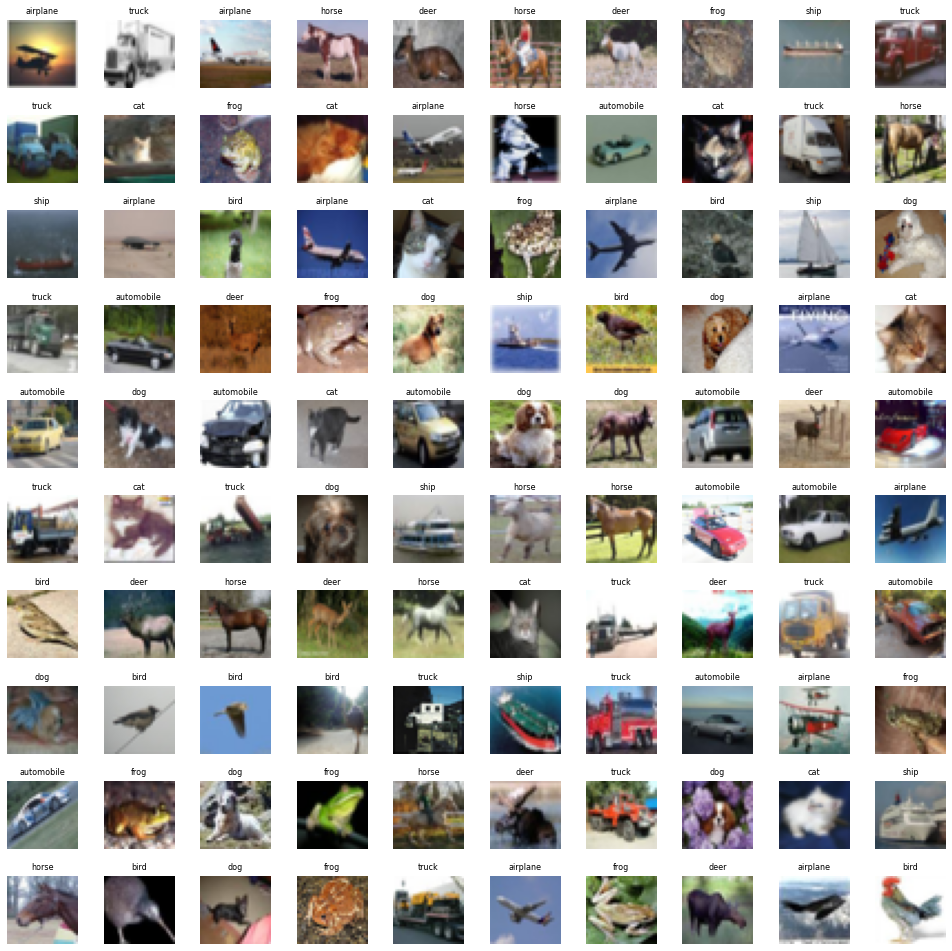

In [3]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10 #100 images

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


Text(0.5, 1.0, 'Class distribution in training set')

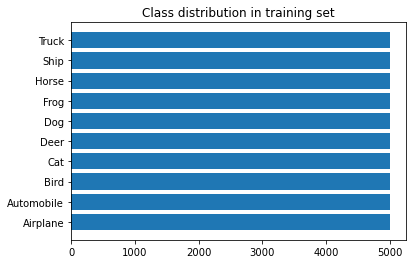

In [4]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

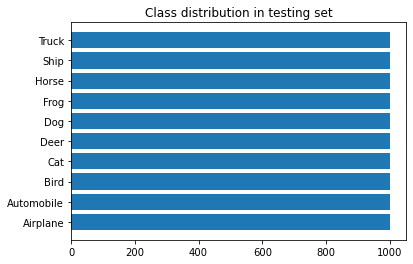

In [5]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

In [6]:
#preprocessing
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [7]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
#model building
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=2) 
#patience - Number of epochs with no improvement after which training will be stopped

In [11]:
#data augmentation
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [12]:
r = model.fit(train_generator, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50
1562/1562 [==============================] - 232s 148ms/step - loss: 1.6311 - accuracy: 0.4106 - precision: 0.6247 - recall: 0.2006 - val_loss: 1.3269 - val_accuracy: 0.5292 - val_precision: 0.6743 - val_recall: 0.3732
Epoch 2/50
1562/1562 [==============================] - 237s 152ms/step - loss: 1.2190 - accuracy: 0.5683 - precision: 0.7290 - recall: 0.4091 - val_loss: 1.8021 - val_accuracy: 0.4414 - val_precision: 0.5648 - val_recall: 0.3304
Epoch 3/50
1562/1562 [==============================] - 3434s 2s/step - loss: 1.0371 - accuracy: 0.6390 - precision: 0.7721 - recall: 0.5089 - val_loss: 0.8938 - val_accuracy: 0.6881 - val_precision: 0.7981 - val_recall: 0.5917
Epoch 4/50
1562/1562 [==============================] - 3519s 2s/step - loss: 0.9315 - accuracy: 0.6778 - precision: 0.7922 - recall: 0.5678 - val_loss: 0.7256 - val_accuracy: 0.7528 - val_precision: 0.8481 - val_recall: 0.6556
Epoch 5/50
1562/1562 [==============================] - 349s 223ms/step - loss: 0.85

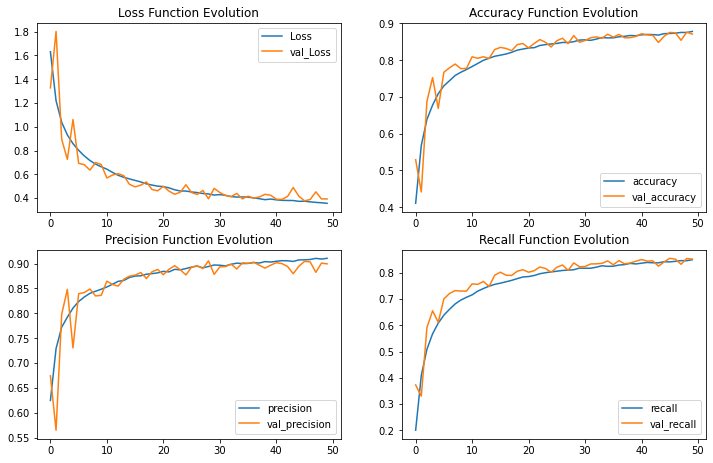

In [13]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 [==============================] - 12s 37ms/step - loss: 0.3926 - accuracy: 0.8711 - precision: 0.8995 - recall: 0.8523
Test Accuracy : 87.11%
313/313 [==============================] - 13s 40ms/step


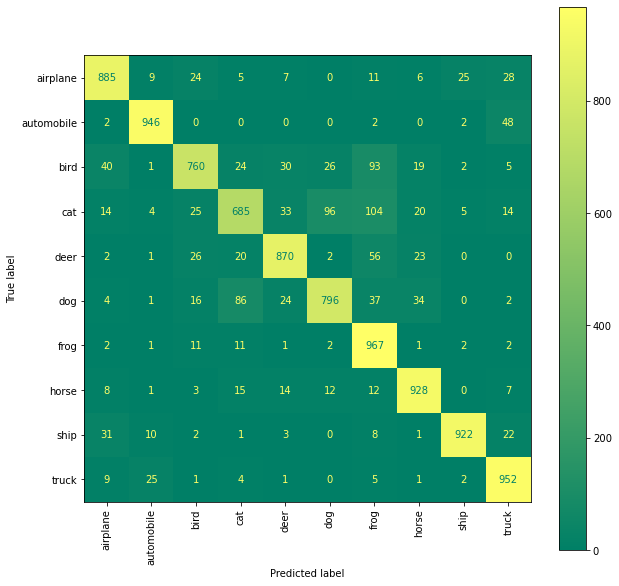

In [14]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1000
           1       0.95      0.95      0.95      1000
           2       0.88      0.76      0.81      1000
           3       0.80      0.69      0.74      1000
           4       0.89      0.87      0.88      1000
           5       0.85      0.80      0.82      1000
           6       0.75      0.97      0.84      1000
           7       0.90      0.93      0.91      1000
           8       0.96      0.92      0.94      1000
           9       0.88      0.95      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



 Image 100 is [4]
1/1 [==============================] - 0s 24ms/step
The model predict that image 100 is 4


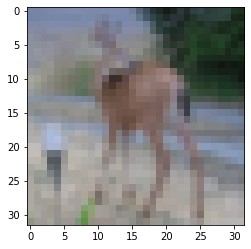

In [16]:
my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

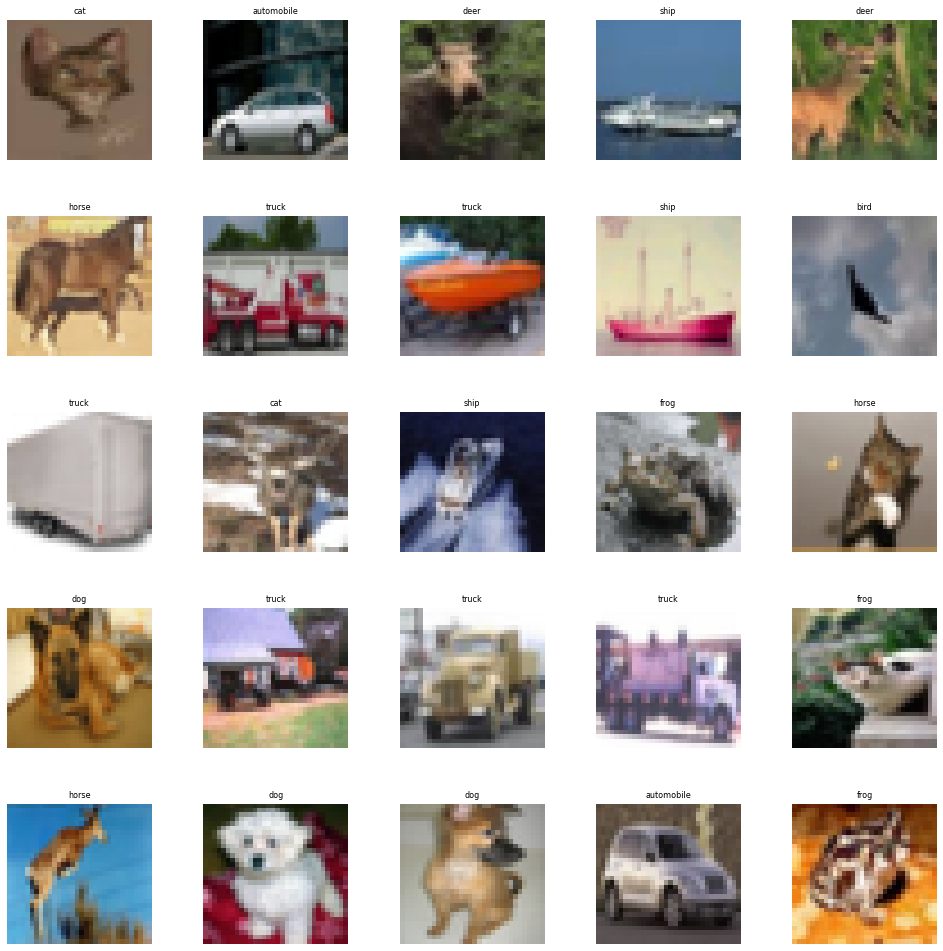

In [17]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [18]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 [==============================] - 11s 35ms/step


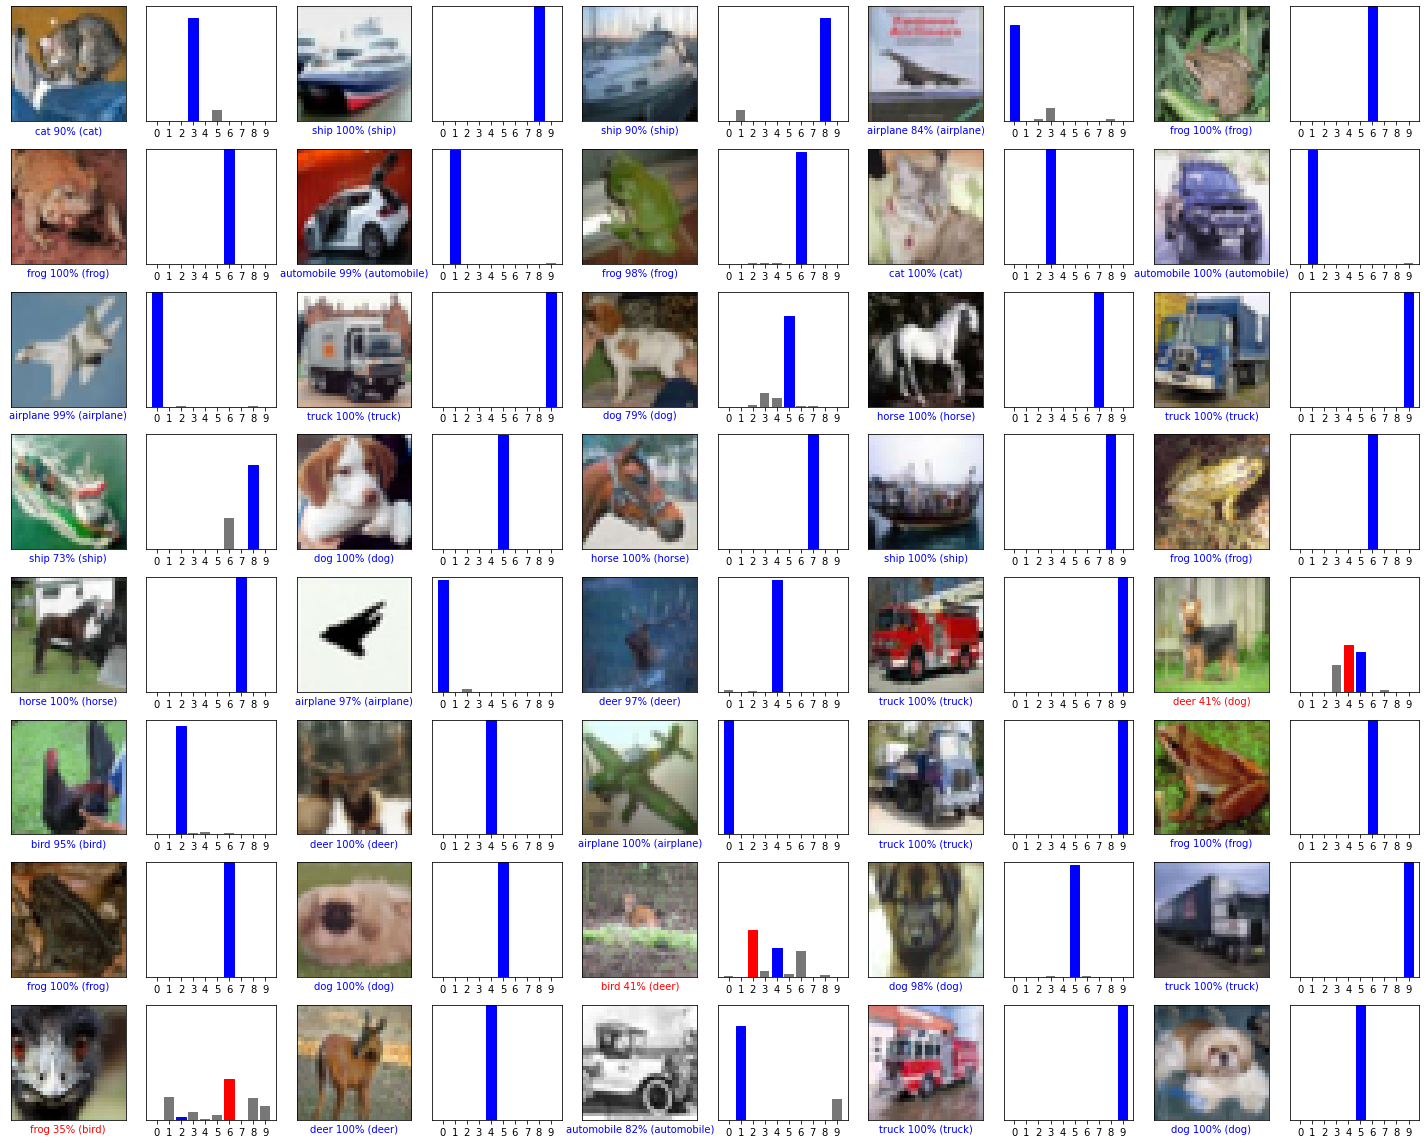

In [19]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [20]:
import shap
def f(x):
    temp=x.copy()
    p=model(temp)
    class_name=np.argmax(p,axis=1)
    #return class_name
    return p

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [21]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)
explainer = shap.Explainer(f, masker,output_names=labels)

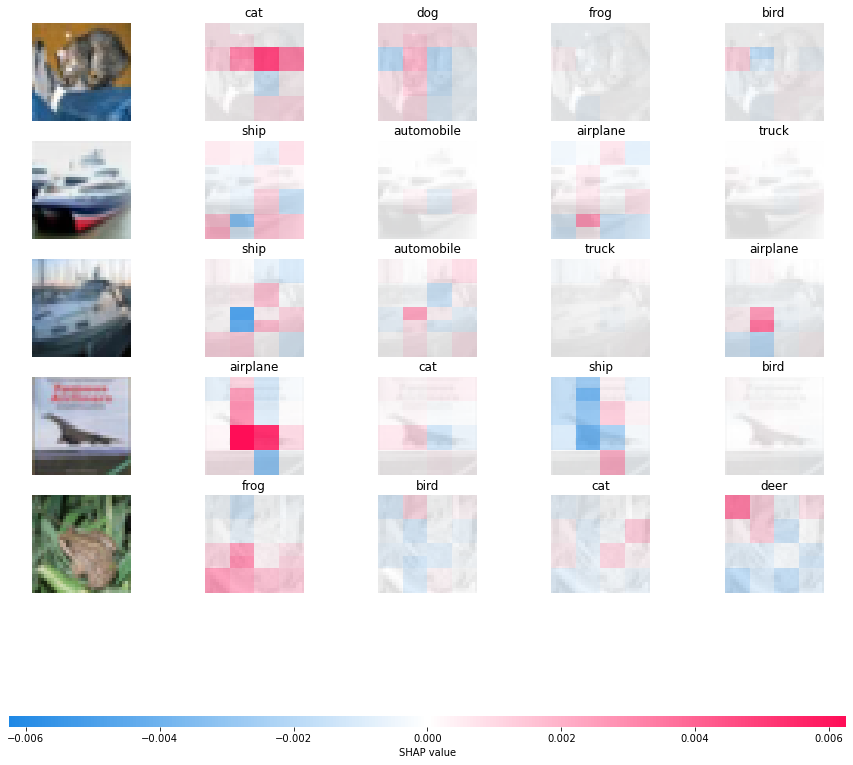

In [22]:
shap_values = explainer(X_test[0:5], max_evals=100, batch_size=50,outputs=shap.Explanation.argsort.flip[:4])
shap.image_plot(shap_values)

  0%|          | 0/4998 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  40%|████████████████████████████▍                                          | 2/5 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  80%|██████████████████████████████████████████████████▍            | 4/5 [00:26<00:04,  4.32s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  6.24s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 6it [00:44, 11.23s/it]                                                                            


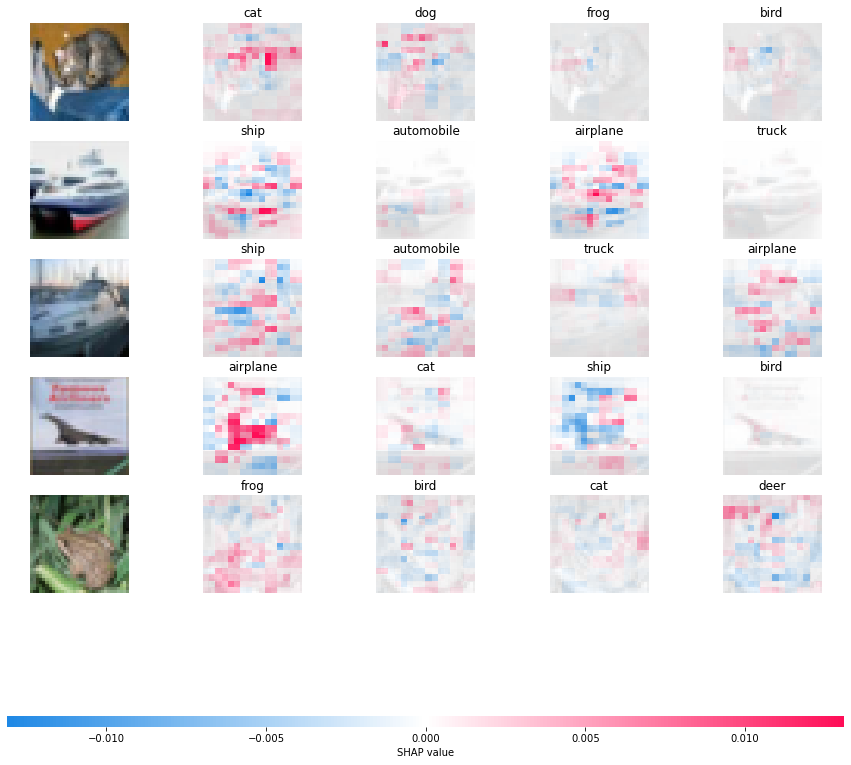

In [23]:
shap_values = explainer(X_test[0:5], max_evals=5000, batch_size=50,outputs=shap.Explanation.argsort.flip[:4])
shap.image_plot(shap_values)

  0%|          | 0/4998 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  40%|████████████████████████████▍                                          | 2/5 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  80%|██████████████████████████████████████████████████▍            | 4/5 [00:26<00:04,  4.81s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  6.98s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 6it [00:46, 11.68s/it]                                                                            


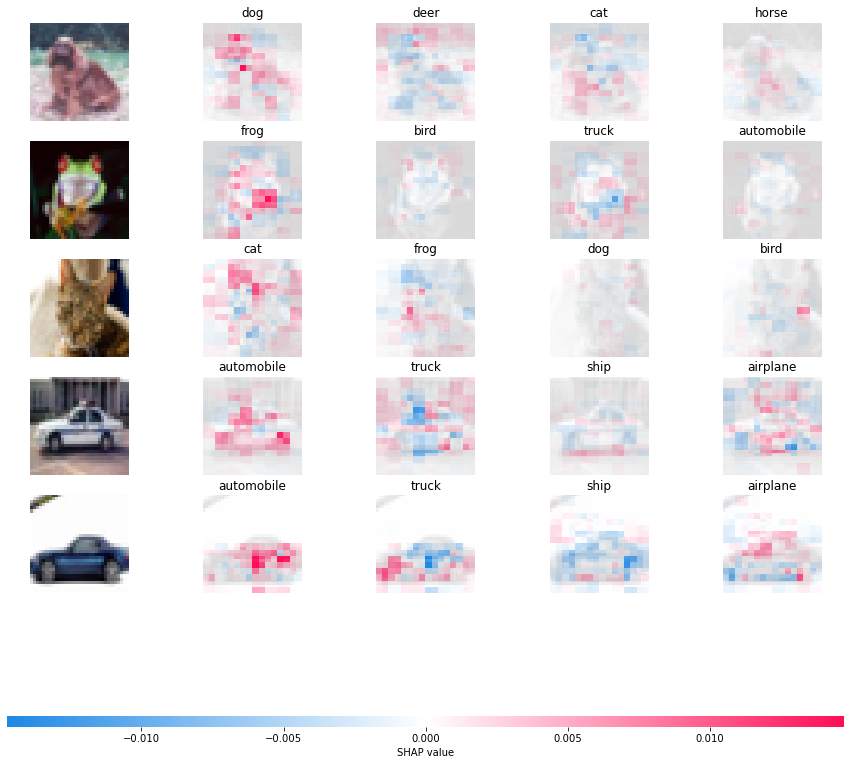

In [24]:
shap_values = explainer(X_test[101:106], max_evals=5000, batch_size=50,outputs=shap.Explanation.argsort.flip[:4])
shap.image_plot(shap_values)

In [25]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [26]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([1, 2, 3])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][4], output[2][5])

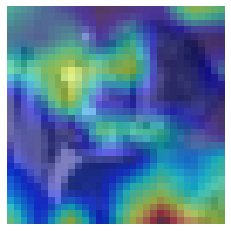

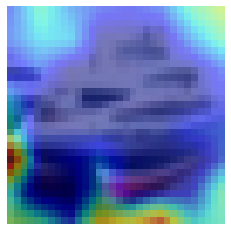

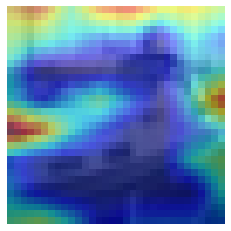

In [28]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X_test[:3],
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
for i in range(3):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    #y=model.predict(X_test[i])
    #yclass = np.argmax(y,axis = 1) 
    #plt.title(yclass)
    plt.imshow(X_test[i])
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()
#cat , ship, ship - titles

1/1 [==============================] - 0s 37ms/step


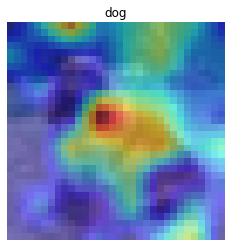

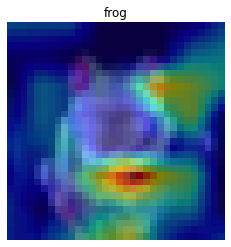

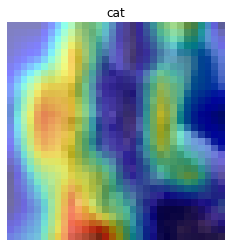

In [33]:
cam = gradcam(score,
              X_test[101:104],
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)
y=model.predict(X_test[101:104])
yclass=np.argmax(y,axis=1)
# Render
for i in range(3):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    #y=model.predict(X_test[i])
    #yclass = np.argmax(y,axis = 1) 
    plt.title(labels[yclass[i]])
    plt.imshow(X_test[i+101])
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 27ms/step


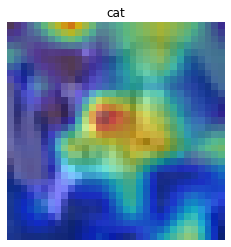

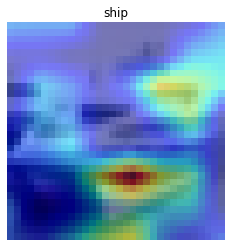

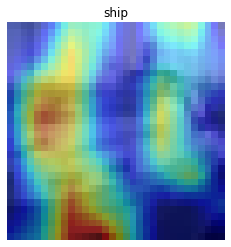

In [35]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcampp = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
campp = gradcampp(score,
              X_test[:3],
              penultimate_layer=-1)
yp03=model.predict(X_test[:3])
yp03class=np.argmax(yp03,axis=1)
for i in range(3):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    #y=model.predict(X_test[i])
    #yclass = np.argmax(y,axis = 1) 
    plt.title(labels[yp03class[i]])
    plt.imshow(X_test[i])
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()

In [36]:
from keras.models import load_model 
model.save("cifarmodel.h5") 